# **AI Based Network Intrusion Detection System**

# NSL-KDD (UCI 1998-99)

The KDD Cup 1999 dataset was created by processing the tcp-dump portion of the 1998 DARPA dataset, which nonetheless suffers from the same issues. This dataset includes more than twenty attacks such as neptune-dos, pod-dos, smurf-dos, buffer-overflow, rootkit, satan, teardrop, to name a few 5. The network traffic records of normal and attack traffics. They are merged together in a simulated environment. This dataset has a large number of redundant records and is studded by data corruptions that led to skewed testing results 6. NSL-KDD was created using KDD dataset 6 to address some of the KDD's shortcomings 3.

Improvements to the KDD'99 data set
    The NSL-KDD data set has the following advantages over the original KDD data set:

    It does not include redundant records in the train set, so the classifiers will not be biased towards more frequent records.

    There is no duplicate records in the proposed test sets; therefore, the performance of the learners are not biased by the methods which have better detection rates on the frequent records.

    The number of selected records from each difficultylevel group is inversely proportional to the percentage of records in the original KDD data set. As a result, the classification rates of distinct machine learning methods vary in a wider range, which makes it more efficient to have an accurate evaluation of different learning techniques.

    The number of records in the train and test sets are reasonable, which makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research works will be consistent and comparable.


# **Overview of the IDS Architecture**

The Intrusion Detection System (IDS) Architecture consists of six major steps:

    1️⃣ Data Collection & Loading → Import NSL-KDD dataset from /datasets folder
    2️⃣ Data Preprocessing → Combine Train and Test Datasets, Split dataset into (Train, Validation, Test Set), Encode categorical features, normalize numerical values
    3️⃣ Define Neural Network Model → Construct an MLP (ANN) model
    4️⃣ Train the Model → Perform forward propagation, loss computation, and backpropagation
    5️⃣ Evaluate Model → Compute accuracy on test set
    6️⃣ Make Predictions → Use the trained model to detect intrusions in new network traffic

In [1]:
# necessary libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

1. Load the Dataset

In [2]:

train_data = pd.read_csv('/home/azureuser/cloudfiles/code/Users/seran.gemechu/datasets/train.csv')
test_data  = pd.read_csv('/home/azureuser/cloudfiles/code/Users/seran.gemechu/datasets/test.csv')

2. Basic Dataset Information & Summary


In [3]:
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: (151165, 42)
Test Data Shape: (34394, 42)


# Data Pre processing & Feature Engineering
3. Drop Duplicates in Each Train and Test data

In [4]:
train_duplicates = train_data.duplicated()
test_duplicates  = test_data.duplicated()

print("\nNumber of duplicate rows in Train Data:", train_duplicates.sum())
print("Number of duplicate rows in Test Data:", test_duplicates.sum())

train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

print("Train Data Shape after dropping duplicates:", train_data.shape)
print("Test Data Shape after dropping duplicates:", test_data.shape)


Number of duplicate rows in Train Data: 25201
Number of duplicate rows in Test Data: 11853
Train Data Shape after dropping duplicates: (125964, 42)
Test Data Shape after dropping duplicates: (22541, 42)


4. Combine the Two Datasets

In [5]:
combined_data = pd.concat([train_data, test_data], ignore_index=True)
print("\nCombined Data Shape:", combined_data.shape)

# Check duplicates again after merging
combined_duplicates = combined_data.duplicated()
print("Number of duplicate rows in Combined Data:", combined_duplicates.sum())

# Drop duplicates in the merged dataset
combined_data.drop_duplicates(inplace=True)
print("Combined Data Shape after dropping duplicates:", combined_data.shape)


Combined Data Shape: (148505, 42)
Number of duplicate rows in Combined Data: 617
Combined Data Shape after dropping duplicates: (147888, 42)


In [6]:
combined_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


5. Visualize Missing Values: Its a clean data

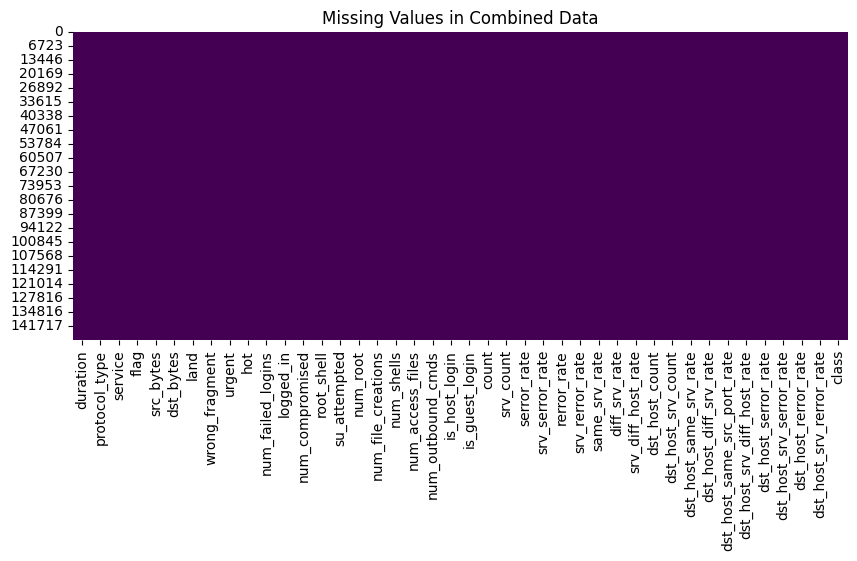

In [7]:
plt.figure(figsize=(10, 4))
sns.heatmap(combined_data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Combined Data")
plt.show()

6. One-Hot Encode Categorical Features

In [8]:
categorical_cols = ["protocol_type", "service", "flag"]
combined_data_encoded = pd.get_dummies(combined_data, columns=categorical_cols)

7. Create Binary Attack Label

In [9]:
combined_data_encoded["attack_binary"] = combined_data_encoded["class"].apply(
    lambda x: 0 if x == "normal" else 1
)
combined_data_encoded.drop(columns=["class"], inplace=True)

In [10]:
combined_data_encoded.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


8. Split the Combined Data —roughly 67% for training, 13% for validation, and 20% for testing

In [20]:
X = combined_data_encoded.drop("attack_binary", axis=1).values  # Features
y = combined_data_encoded["attack_binary"].values               # Labels

# Split 67% for training, 20% for final test
# 'stratify=y' helps preserve class distribution
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# further split 13% for validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.16, random_state=42, stratify=y_trainval
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 99380
Validation set size: 18930
Test set size: 29578


9. Create a Custom PyTorch Dataset

In [21]:
class IntrusionDataset(Dataset):
    '''
    Convert features to a torch tensor of type float32.
    Convert labels to a torch tensor of type float32 
    and add an extra dimension for compatibility.
    '''
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.labels)  # Returns the total number of samples.
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]  # Retrieves the sample and corresponding label at the specified index.

10. Create Dataset & DataLoaders

In [22]:
train_dataset = IntrusionDataset(X_train, y_train)
val_dataset   = IntrusionDataset(X_val,   y_val)
test_dataset  = IntrusionDataset(X_test,  y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("\nTrain Dataset - Features shape:", train_dataset.features.shape)
print("Train Dataset - Labels shape:",   train_dataset.labels.shape)

print("Val Dataset   - Features shape:", val_dataset.features.shape)
print("Val Dataset   - Labels shape:",   val_dataset.labels.shape)

print("Test Dataset  - Features shape:", test_dataset.features.shape)
print("Test Dataset  - Labels shape:",   test_dataset.labels.shape)



Train Dataset - Features shape: torch.Size([99380, 122])
Train Dataset - Labels shape: torch.Size([99380, 1])
Val Dataset   - Features shape: torch.Size([18930, 122])
Val Dataset   - Labels shape: torch.Size([18930, 1])
Test Dataset  - Features shape: torch.Size([29578, 122])
Test Dataset  - Labels shape: torch.Size([29578, 1])


#   MLP Neural Network Model 


**Model Architecture**

- **Input Layer**: 41+ features  
- **Hidden Layers**:  
  - 128 neurons  
  - 64 neurons  
  - 32 neurons  
  - Using Forward & Backward Propagation with ReLU activation  
- **Output Layer**: 1 neuron with Sigmoid activation (binary classification)

**Performance Evaluation**  
- Accuracy  
- Precision  
- Recall (Sensitivity)  
- F1-Score  
- Confusion Matrix (CM)  


In [23]:
class MLP(nn.Module):
    '''
    Layer 1: input_dim -> 128 neurons.
    Layer 2: 128 -> 64 neurons.
    Layer 3: 64 -> 32 neurons.
    Output Layer: 32 -> 1 neuron.
    '''
    def __init__(self, input_dim):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

        # Activation functions.
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply fc1 followed by ReLU.
        x = self.relu(self.fc1(x))

        # Apply fc2 followed by ReLU.
        x = self.relu(self.fc2(x))

        # Apply fc3 followed by ReLU.
        x = self.relu(self.fc3(x))

        # Apply fc4 followed by Sigmoid to output a probability.
        x = self.sigmoid(self.fc4(x))
        return x

# Get the number of input features [41]
input_dim = X_train.shape[1]

# Instantiate the model.
model = MLP(input_dim)
print("Model architecture:\n", model)

# ------------------------------------------------------------------------------------
#                       7. Loss Function and Optimizer
# ------------------------------------------------------------------------------------
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification.
optimizer = optim.Adam(model.parameters(), lr=0.001)  #learning rate = 0.001


# ------------------------------------------------------------------------------------
#                   8. Training Loop with Validation and Early Stopping
# ------------------------------------------------------------------------------------
num_epochs = 200           # Maximum number of epochs.
patience = 15              # Early stopping.
best_val_loss = float('inf')  # Initialize best validation loss to infinity.
epochs_no_improve = 0      # Counter for epochs with no improvement.

# Lists for storing metrics and later plotting.
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # ------------------------- TRAINING PHASE -------------------------
    # Set model to training mode.
    model.train()  
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(batch_features)  # Forward pass
        loss = criterion(outputs, batch_labels)  # Compute loss
        loss.backward()  # Backprop
        optimizer.step()  # Update model parameters
        
        # Accumulate training loss
        running_train_loss += loss.item() * batch_features.size(0)

        # Calculate number of correct predictions
        preds = (outputs > 0.5).float()
        total_train += batch_labels.size(0)
        correct_train += (preds == batch_labels).sum().item()

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ------------------------- VALIDATION PHASE -------------------------
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_features, val_labels in val_loader:
            outputs = model(val_features)  # Forward pass on validation data
            loss = criterion(outputs, val_labels)
            running_val_loss += loss.item() * val_features.size(0)
            preds = (outputs > 0.5).float()
            total_val += val_labels.size(0)
            correct_val += (preds == val_labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # ------------------------- EARLY STOPPING CHECK -------------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Update best loss
        epochs_no_improve = 0         # Reset counter if improvement is seen
        # Save the best model 
        # torch.save(model.state_dict(), "nids_best_model_final.pt")

    else:
        epochs_no_improve += 1        # Increment counter if no improvement
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break



Model architecture:
 MLP(
  (fc1): Linear(in_features=122, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Epoch 1/200 | Train Loss: 1.5638, Train Acc: 0.9272 | Val Loss: 0.6056, Val Acc: 0.9531
Epoch 2/200 | Train Loss: 1.0031, Train Acc: 0.9530 | Val Loss: 1.3624, Val Acc: 0.9576
Epoch 3/200 | Train Loss: 1.1558, Train Acc: 0.9604 | Val Loss: 0.4964, Val Acc: 0.9740
Epoch 4/200 | Train Loss: 0.7588, Train Acc: 0.9659 | Val Loss: 0.0855, Val Acc: 0.9684
Epoch 5/200 | Train Loss: 0.1048, Train Acc: 0.9667 | Val Loss: 0.0838, Val Acc: 0.9704
Epoch 6/200 | Train Loss: 0.0924, Train Acc: 0.9674 | Val Loss: 0.0821, Val Acc: 0.9633
Epoch 7/200 | Train Loss: 0.0824, Train Acc: 0.9705 | Val Loss: 0.0643, Val Acc: 0.9735
Epoch 8/200 | Train Loss: 0.0885, Train Acc: 0.9696 | Val Loss: 0.1865, Va

Training/Validation Curve Plots

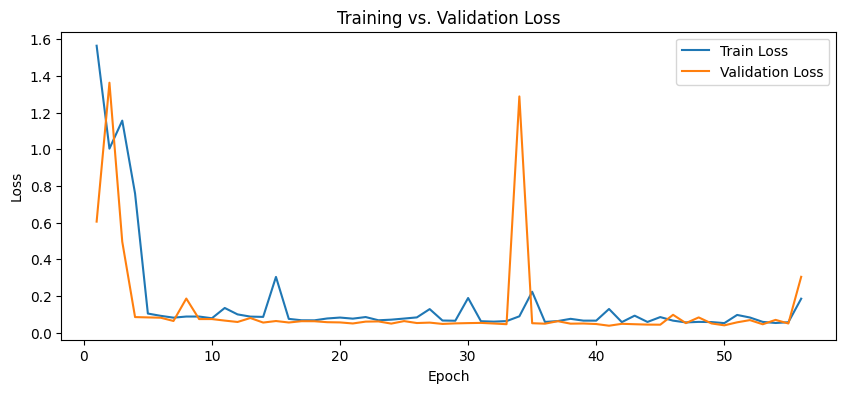

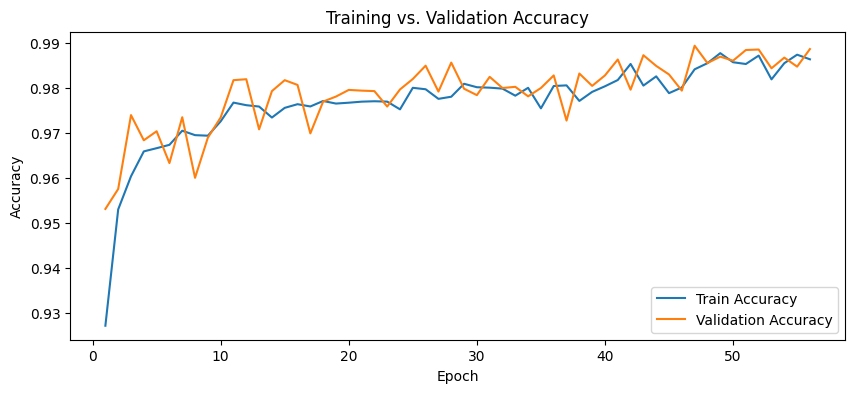

In [24]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

 9. Final Evaluation on Test Set with Detailed Metrics

In [25]:
# Set model to evaluation mode (disables dropout, batch norm updates, etc.)
model.eval() 

# Initialize accumulators for test loss and accuracy
test_running_loss = 0.0
correct_test = 0
total_test = 0

# Lists to store predictions and true labels for further analysis (ex. confusion matrix)
all_predictions = []
all_true = []

# Disable gradient computation for faster inference and to save memory
with torch.no_grad():
    # Iterate over the test set batches
    for test_features, test_labels in test_loader:
        # Forward pass: compute model outputs (predicted probabilities)
        outputs = model(test_features)
        
        # Compute the loss for the current batch and accumulate it
        loss = criterion(outputs, test_labels)
        test_running_loss += loss.item() * test_features.size(0)
        
        # Convert model outputs to binary predictions using a threshold of 0.5
        predictions = (outputs > 0.5).float()
        
        # Accumulate the total number of test samples and count correct predictions
        total_test += test_labels.size(0)
        correct_test += (predictions == test_labels).sum().item()
        
        # Flatten the predictions and true labels (to 1D arrays) and extend the lists
        all_predictions.extend(predictions.numpy().flatten())
        all_true.extend(test_labels.numpy().flatten())


# Calculate average test loss over the entire test dataset
test_loss = test_running_loss / len(test_loader.dataset)

# Calculate overall test accuracy
test_accuracy = correct_test / total_test

# Print the final evaluation metrics
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Test Loss: 0.3036, Test Accuracy: 0.9886


## **Results: Evaluation metrics and Classification Report**


------------------Classification Report on Test Set------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     15394
         1.0       0.99      0.99      0.99     14184

    accuracy                           0.99     29578
   macro avg       0.99      0.99      0.99     29578
weighted avg       0.99      0.99      0.99     29578



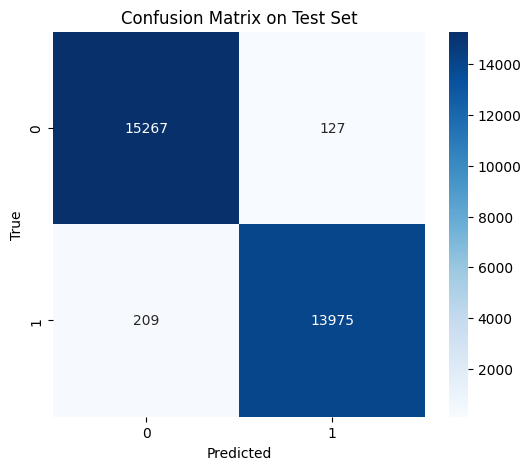

In [31]:
# Evaluation metrics 
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix

print("------------------Classification Report on Test Set------------------")
print(classification_report(all_true, all_predictions))

# Compute and plot the confusion matrix
cm = confusion_matrix(all_true, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Set")
plt.show()

##### Summary
    True Negatives (TN) = 15,267
    False Positives (FP) = 127
    False Negatives (FN) = 209
    True Positives (TP) = 13,975
    Total Instances = TN + FP + FN + TP = 29,578


    Accuracy: 98.86%
    Precision (Class 1): 99.09%
    Recall (Class 1): 99%
    F1-Score (Class 1): 99%